# Predicting transcription factor-DNA binding from sequence

## Changes
Convolving 26 PWMs together
& increased no. of parameters
Random initialization

### Setup

In [108]:
!pip install bio

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import matplotlib.pyplot as plt
from Bio import SeqIO
from scipy.stats import pearsonr

%matplotlib inline

In [110]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [111]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [112]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


##Data Path

In [113]:
data_path = "drive/My Drive/CS582-Project/Datasets/topic1-data/"
res_folder = "drive/My Drive/CS582-Project/Result/M4"
batch_size = 100
validation_ratio = 0.2

### Reading Transcription Factors

In [114]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

### Preprocessing & Reading Data

In [115]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')
   encoder.fit([['A'], ['C'], ['G'], ['T']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [116]:
def compute_correlation(binding, tf_list, filename):
  #print("H2")
  #print(binding.shape)
  tf_pair = []
  correlation = []
  pvalue = []
  for tf1 in range(len(tf_list)):
    bind1 = binding[:, tf1]
    #print(bind1.shape)
    for tf2 in range(len(tf_list)):
      if(tf1 != tf2):
        bind2 = binding[:, tf2]
        #print(bind2.shape)
        names = tf_list[tf1] + ":" + tf_list[tf2]
        pear = pearsonr(bind1, bind2)
        #print("H3")
        tf_pair.append(names)
        correlation.append(pear[0])
        pvalue.append(pear[1])
  tf_pair = np.array(tf_pair).reshape(-1, 1)
  correlation = np.array(correlation).reshape(-1, 1)
  pvalue = np.array(pvalue).reshape(-1, 1)
  data = np.concatenate([tf_pair, correlation, pvalue], axis=1)
  cols = ['TF-Pair', 'Correlation', 'P-Value']

  df = pd.DataFrame(data, columns=cols)
  df.to_csv(filename, sep='\t', index=False)
  #print("H2")

In [117]:
def get_data(data_path, tf_list, data_type): # type = "train"/"test"
  dataset = []
  for i in range(len(tf_list)):
    tf = tf_list[i]
    #print('=========== ', tf, ' ===========')
    sequence_path = data_path + '/' + tf + '/' + tf + '-' + data_type + '-sequence.fa'
    binding_path = data_path + '/' + tf + '/' + tf + '-' + data_type + '.bed'
    sequence = pd.DataFrame(np.array([list(record.seq.__str__().upper())
                  for record in SeqIO.parse(sequence_path, "fasta")]))
    binding = pd.read_csv(binding_path, sep='\t', header=None, names=['desc', tf]).drop(labels='desc', axis=1)
    data = pd.concat([sequence, binding], axis=1)
    dataset.append(data)
  seq_len = len(dataset[0].columns) - 1
  #print(seq_len)
  dataset = pd.concat(dataset, axis=1, join="inner")
  dataset = dataset.loc[:,~dataset.columns.duplicated()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  dataset.to_csv(res_folder + '/' + data_type + '-dataset.csv')
  sequence = dataset.iloc[:, 0:seq_len]
  binding = dataset.iloc[:, seq_len:]
  binding = binding.to_numpy()
  print("Here")
  compute_correlation(binding, tf_list, res_folder + '/' + 'magnitude-correlation.tsv')
  print("Here")
  #print(binding.shape)
  #sequence = dataset.iloc[:, 0:seq_len]
  sequence = sequence.to_numpy()
  sequence = sequence.reshape(sequence.shape[0], -1, 1)
  #print(sequence[0])
  sequence = np.array([one_hot_encoder(row) for row in sequence], dtype='float32')
  binding = binding / binding.max(axis=0)
  #df = pd.DataFrame(binding, columns = tf_list)
  #df.to_csv('Binding.tsv', sep='\t')
  compute_correlation(binding, tf_list, res_folder + '/' + 'normalized-correlation.tsv')
  #binding = np.log2(binding + 0.5)
  #print(binding)
  #print(sequence.shape)
  #print(sequence[0])
  #print(atcg_ratio)
  
  return {'seq': sequence, 'chip': binding}

In [118]:
def get_symbol_ratio(sequence):
  seq_shape = sequence.shape
  atcg_ratio = np.sum(np.sum(sequence, axis=1), axis=0)/(seq_shape[0] * seq_shape[1])
  return atcg_ratio

In [119]:
def get_pwm_list(data_path, tf_list, file_ext, non_site_prob):
  pwm_files = [data_path + '/' + tf + '/' + tf + file_ext for tf in tf_list]
  tf_cnt = len(tf_list)
  #print(pwm_files)
  pwm_list = [normalize(pd.read_csv(pwm_file, names = ['A', 'C', 'G', 'T'], sep="\t", header=None,
                          skiprows=1, skipfooter=1, dtype='float32', engine='python')
                          .to_numpy(), axis=1, norm='l1')
                          for pwm_file in pwm_files]
  #print(pwm_list)
  length = np.array([pwm.shape[0] for pwm in pwm_list])
  max_length = length.max()
  append = max_length - length
  append_up = append // 2
  append_down = append - append_up
  arr_up = np.array([np.repeat([non_site_prob], append_up[i], axis=0) for i in range(tf_cnt)])
  arr_down = np.array([np.repeat([non_site_prob], append_down[i], axis=0) for i in range(tf_cnt)])
  pwm_list = np.array([np.concatenate((arr_up[i], pwm_list[i], arr_down[i]), axis=0)
                      .reshape(1, max_length, 4).astype('float32')
                      for i in range(tf_cnt)])
  #print('pwm_list', pwm_list)
  #print('shape ', pwm_list.shape)
  return pwm_list

##Custom Dataset

In [120]:
class TFBindingDataset(Dataset):
    def __init__(self, data):
        super(TFBindingDataset, self).__init__()
        self.X = torch.from_numpy(data['seq'])
        shape = self.X.shape
        self.X = self.X.reshape(shape[0], 1, shape[1], shape[2])
        self.y = torch.from_numpy(data['chip'])

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

### Binding Score

In [121]:
def get_binding_values(data_loaders, tf_list):
    binding_dict = {}
    for i in range(len(tf_list)):
      binding_values = []
      for data_loader in data_loaders:
        for data in data_loader:
            _, y = data
            y = y[:, i]
            binding_values.extend(torch.reshape(y, (-1,)))
      binding_values = torch.stack(binding_values)
      binding_dict[tf_list[i]] = binding_values
    return binding_dict

### Model

In [122]:

class BindingPredictionCNN(Module):
    def __init__(self, weight):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=26, kernel_size=(30, 4), stride=1)
        #with torch.no_grad():
            #self.conv1.weight = nn.Parameter(weight)
        self.conv2 = Conv1d(in_channels=26, out_channels=26, kernel_size=40, stride=1)
        self.drop = nn.Dropout(0.2)

        self.fc1 = Linear(in_features=1014, out_features=750)
        self.out = Linear(in_features=750, out_features=26)


    def forward(self, x):
        x = F.relu(self.conv1(x)).squeeze()
        x = F.max_pool1d(x, 4 , 4)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

##Plots

In [123]:
def plot_binding_histogram(data_loaders, tf_list):
    binding_dict = get_binding_values(data_loaders, tf_list)
    #print(len(binding_dict))
    for tf in tf_list:
      #print(tf)
      binding_values = binding_dict[tf]
      #print(binding_values)
      plt.figure(figsize=(7,7))
      plt.title(tf + " Bindings Histogram")
      plt.xlabel("Binding Value")
      plt.ylabel("Count")
      plt.hist(binding_values, bins=40)
      plt.savefig(res_folder + '/' + tf + '-histogram.png')

In [124]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)
    return {'accuracy': accuracy, 'sensitivity': sensitivity, 'specificity': specificity, 'f1score': f1_score}

In [125]:
def plot_loss(train_log, train_log1, val_log, epoch_num):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    #plt.plot(range(1, epoch_num + 1), train_log1, color='C2', label='training1')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.savefig(res_folder + '/' + 'Loss.png')
    plt.show()

In [126]:
def roc_auc_curve_plot(y_true_binary, y_pred_binary, tf):
  fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
  auc = roc_auc_score(y_true_binary, y_pred_binary)
  plt.figure(figsize=(7,7))
  plt.plot(fpr, tpr, label="auc="+str(auc))
  plt.title('ROC-AUC for Classification Task - ' + tf)
  plt.xlabel('1 - Specificity')
  plt.ylabel('Sensitivity')
  plt.legend(loc='best')
  plt.legend()
  plt.savefig(res_folder + '/' + tf + '-roc.png')
  plt.show()
  return auc

##Training

In [127]:
def train(net, train_loader, val_loader, optimizer, criterion, device, epoch_num):
    train_log = []
    val_log = []
    train_log1 = []
    lambda1 = 0.00005
    lambda2 = 0.000005
    flag = True
    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            #print(outputs)
            #print(y)
            loss = criterion(outputs.float(), y.float())
            """
            params = []
            for param in net.parameters():
              params.append(param.view(-1))
            params = torch.cat(params)
            l1_loss = lambda1 * torch.abs(params).sum()
            l2_loss = lambda2 * torch.square(params).sum()
            loss += l1_loss + l2_loss"""
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        
        flag = np.around(np.mean(train_loss), decimals=3) > 0
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')
        
        train_loss1 = []
        net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(train_loader, desc='Train1 ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                train_loss1.append(loss.item())
        train_log1.append(np.mean(train_loss1))
        
        print('train1 loss: %.3f' % np.mean(train_loss1), flush=True, end='')

        test_loss = []
        #net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss))
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
        if not (flag):
          break
    return train_log, train_log1, val_log

##Train Evaluation

In [128]:
tf_list = get_tf_list(data_path)

In [129]:
train_data = get_data(data_path, tf_list, "train")
train_set = TFBindingDataset(train_data)
atcg_ratio = get_symbol_ratio(train_data['seq'])
weight = torch.from_numpy(get_pwm_list(data_path, tf_list, "_GM12878_4.wtmx", atcg_ratio))
 
train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
model = BindingPredictionCNN(weight)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)


Here
Here
BindingPredictionCNN(
  (conv1): Conv2d(1, 26, kernel_size=(30, 4), stride=(1, 1))
  (conv2): Conv1d(26, 26, kernel_size=(40,), stride=(1,))
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1014, out_features=750, bias=True)
  (out): Linear(in_features=750, out_features=26, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [130]:
epoch_count = 300

In [131]:
train_log, train_log1, val_log = train(model, train_loader, val_loader, optimizer, criterion, device, epoch_count)


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 0.018

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.010

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.010

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f9714c53950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


============ epoch 70 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 81:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 82:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 83:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 84:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 85:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 86:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 87:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 88:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 89:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 90:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 91:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 92:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 93:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 94:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 95:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 96:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 97:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 98:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 99:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 100:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 101:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 101 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 102:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 102 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 103:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 103 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 104:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 104 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 105:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 105 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 106:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 106 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 107:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 107 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 108:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 108 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 109:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 109 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 110:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 110 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 111:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 111 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 112:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 112 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 113:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 113 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 114:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 114 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 115:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 115 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 116:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 116 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 117:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 117 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 118:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 118 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 119:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 119 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 120:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 120 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 121:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 121 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 122:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 122 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 123:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 123 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 124:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 124 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 125:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 125 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 126:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 126 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 127:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 127 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 128:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 128 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.012

Training epoch 129:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 129 =============
train loss: 0.000

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

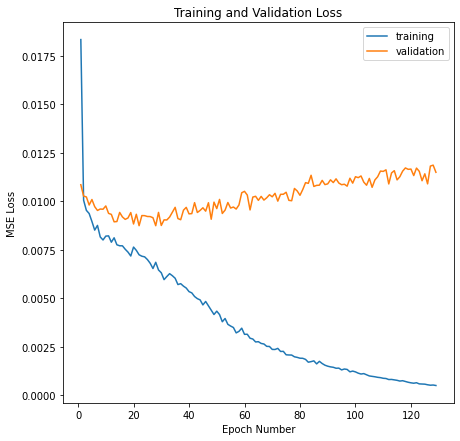

In [133]:
plot_loss(train_log, train_log1, val_log, len(train_log))

In [134]:
torch.save(model.state_dict(), 'drive/My Drive/CS582-Project/Models/M4')

##Testing

In [135]:
def test(net, test_loader, device):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):
            x_input, labels = x_input.to(device), labels.to(device)
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

##Test Evaluation

In [136]:
test_data = get_data(data_path, tf_list, "test")
test_set = TFBindingDataset(test_data)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                        shuffle=True)
y_true, y_pred = test(model, test_loader, device)

Here
Here


Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [137]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.019237656


### Classification

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


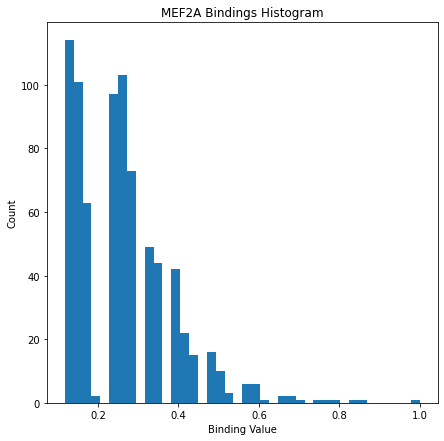

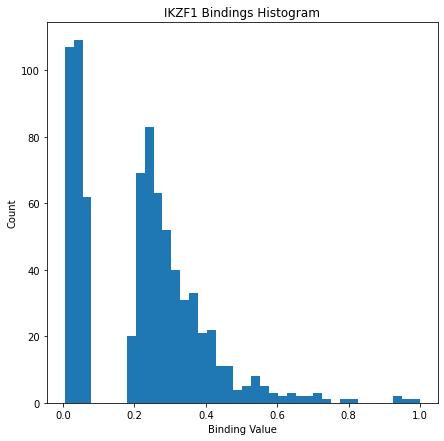

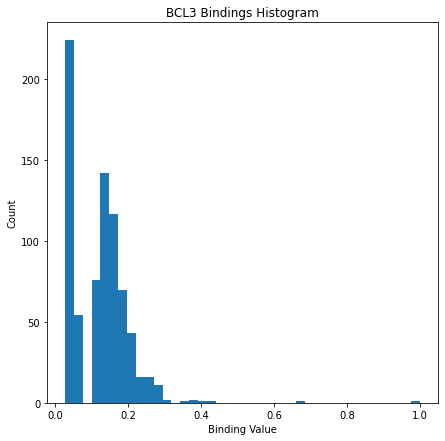

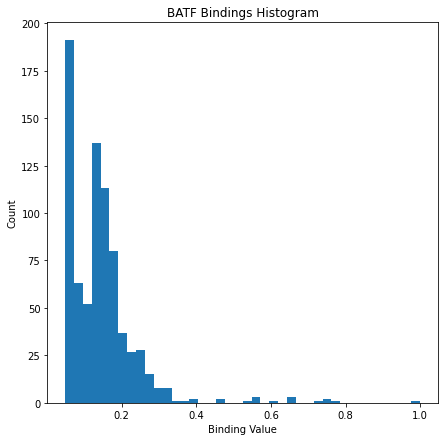

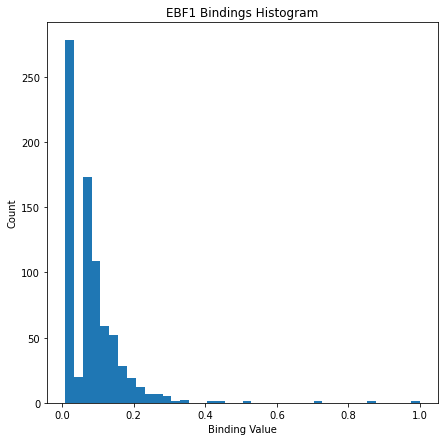

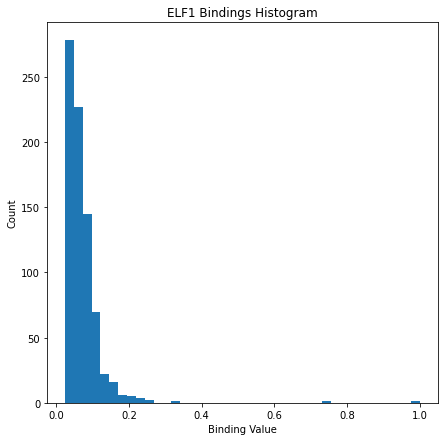

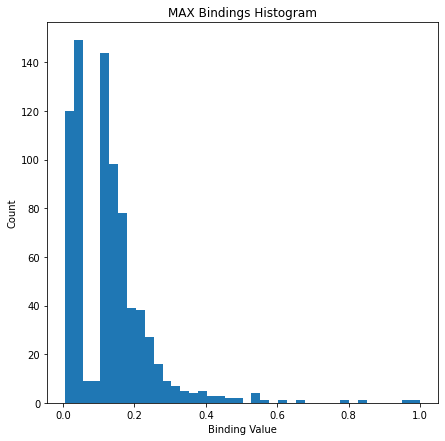

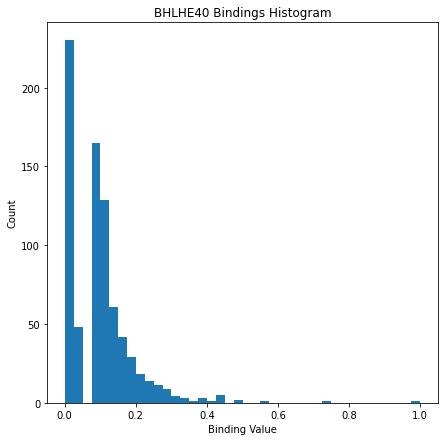

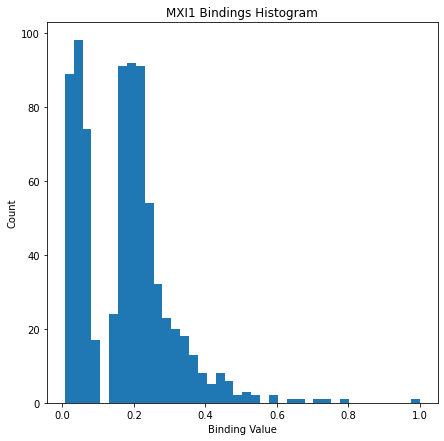

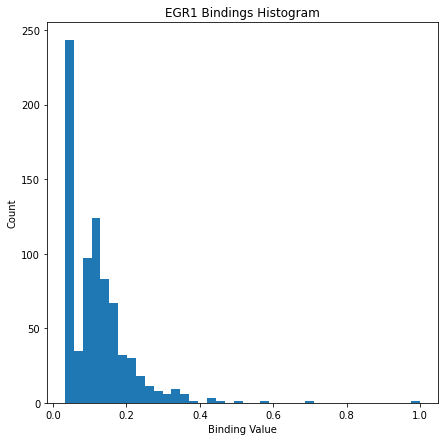

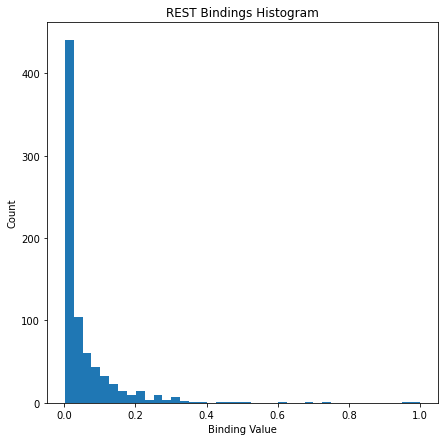

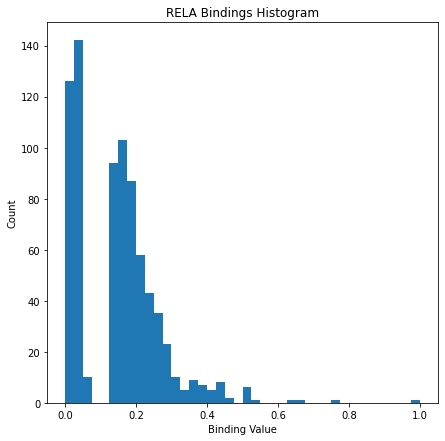

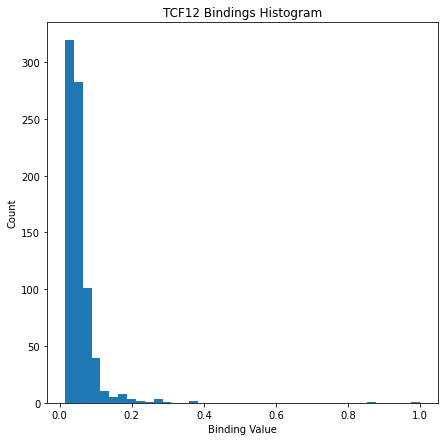

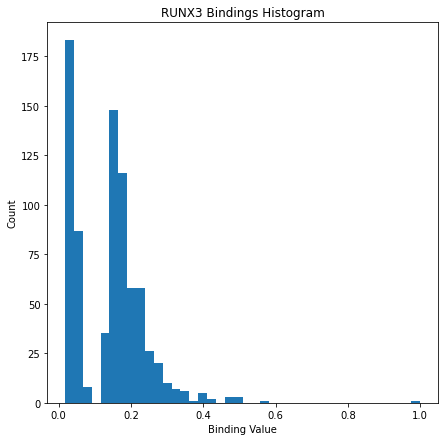

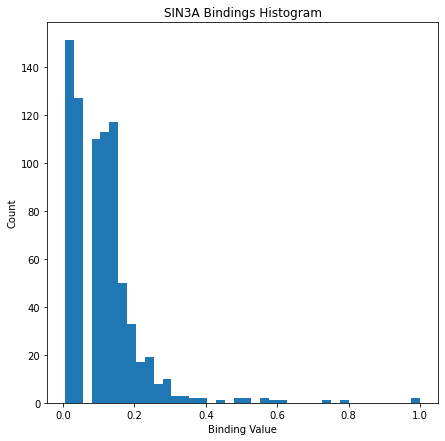

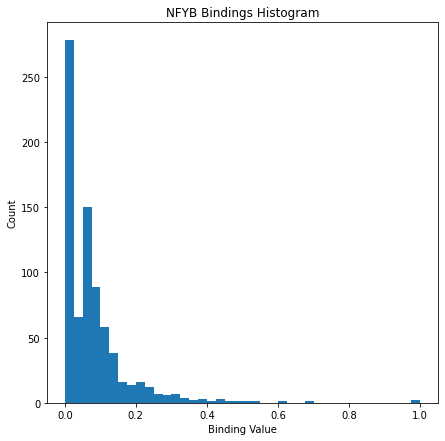

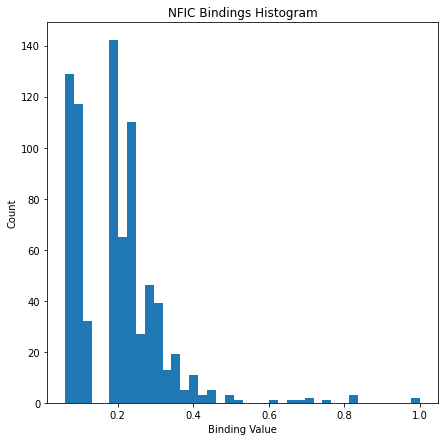

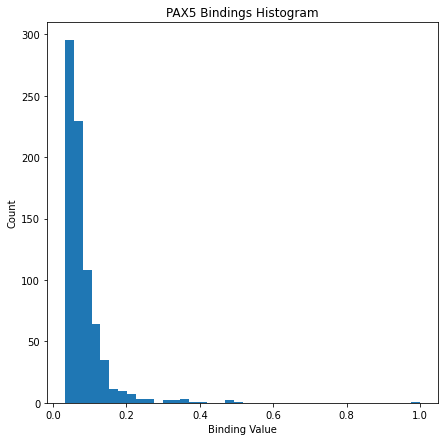

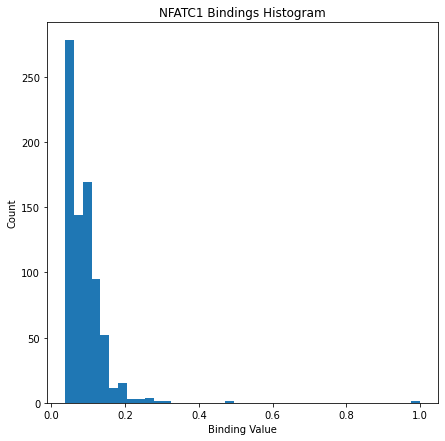

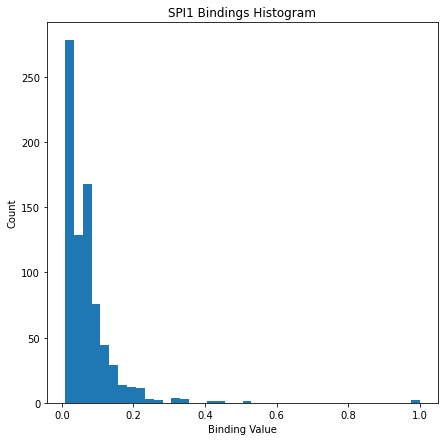

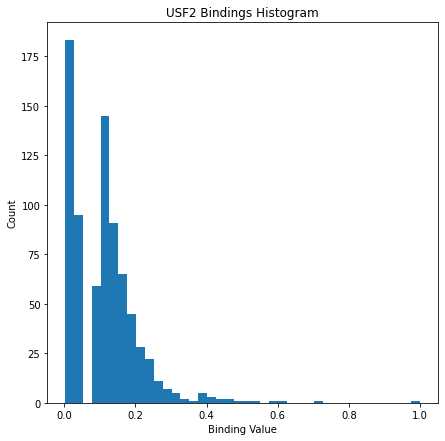

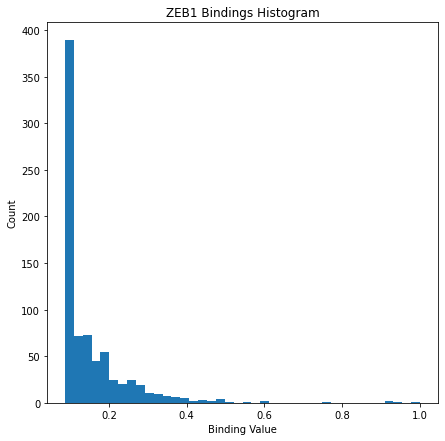

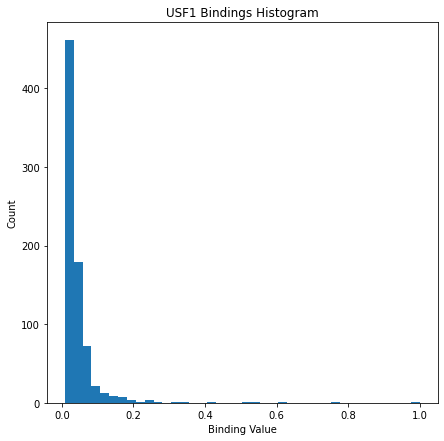

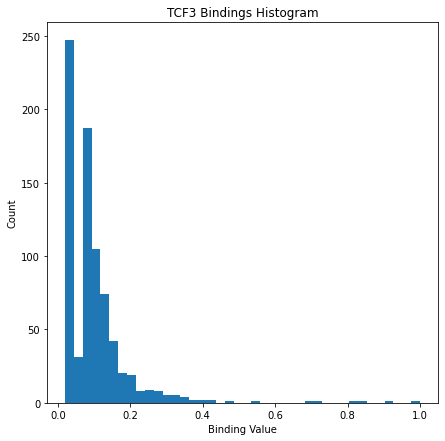

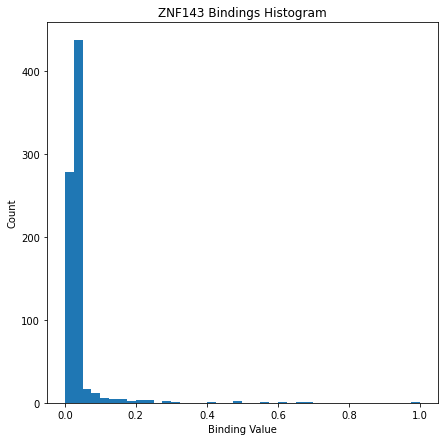

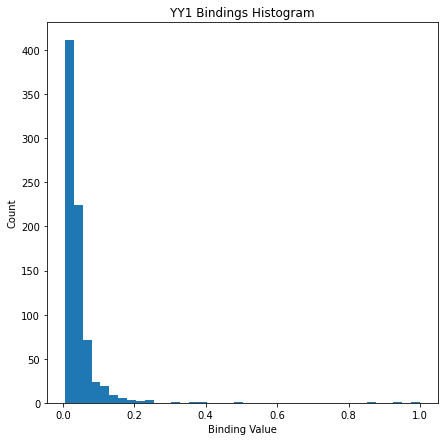

In [138]:
plot_binding_histogram([train_loader, val_loader], tf_list)

In [139]:
binding_dict = get_binding_values([train_loader, val_loader], tf_list)
#for (key, value) in binding_dict.items():
#  print(len(value))

In [140]:
print(y_true.shape)
print(y_pred.shape)

(400, 26)
(400, 26)


================  MEF2A  ================
0.26273979911906514
[[170  98]
 [ 48  84]]
              precision    recall  f1-score   support

           0       0.78      0.63      0.70       268
           1       0.46      0.64      0.54       132

    accuracy                           0.64       400
   macro avg       0.62      0.64      0.62       400
weighted avg       0.67      0.64      0.65       400

=== Statistics ===
Test Accuracy: 0.635
Test Sensitivity: 0.636
Test Specificity: 0.634
Test F1-Score: 0.535


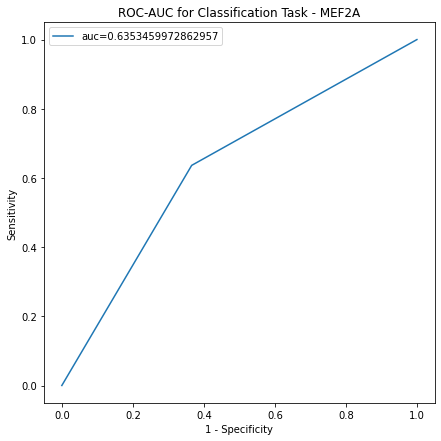

================  IKZF1  ================
0.22016896823448862
[[138 112]
 [ 75  75]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       250
           1       0.40      0.50      0.45       150

    accuracy                           0.53       400
   macro avg       0.52      0.53      0.52       400
weighted avg       0.56      0.53      0.54       400

=== Statistics ===
Test Accuracy: 0.532
Test Sensitivity: 0.500
Test Specificity: 0.552
Test F1-Score: 0.445


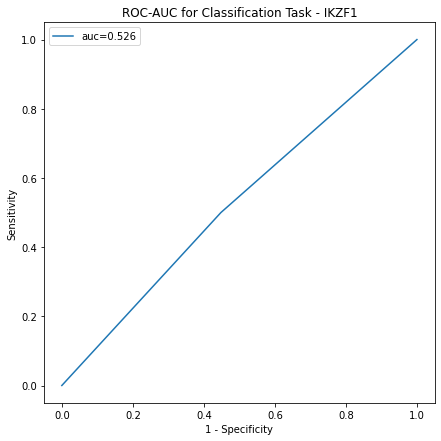

================  BCL3  ================
0.12074754422425077
[[114 100]
 [ 92  94]]
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       214
           1       0.48      0.51      0.49       186

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400

=== Statistics ===
Test Accuracy: 0.520
Test Sensitivity: 0.505
Test Specificity: 0.533
Test F1-Score: 0.495


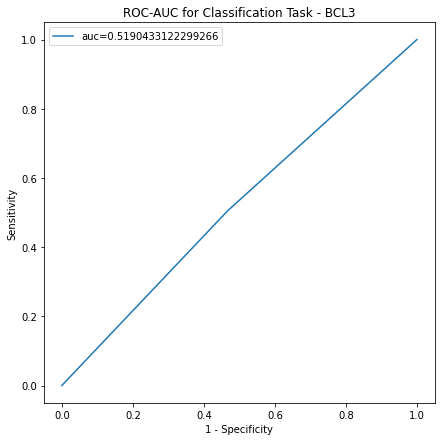

================  BATF  ================
0.14156077590307864
[[180 133]
 [ 51  36]]
              precision    recall  f1-score   support

           0       0.78      0.58      0.66       313
           1       0.21      0.41      0.28        87

    accuracy                           0.54       400
   macro avg       0.50      0.49      0.47       400
weighted avg       0.66      0.54      0.58       400

=== Statistics ===
Test Accuracy: 0.540
Test Sensitivity: 0.414
Test Specificity: 0.575
Test F1-Score: 0.281


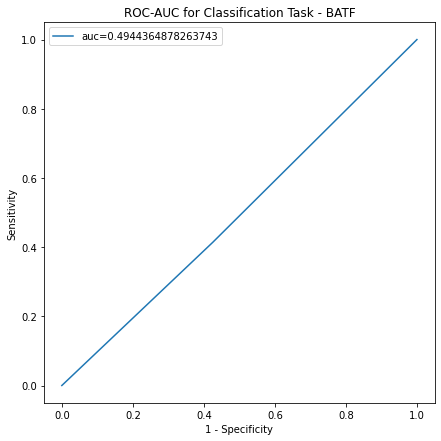

================  EBF1  ================
0.07934129723797231
[[165 136]
 [ 56  43]]
              precision    recall  f1-score   support

           0       0.75      0.55      0.63       301
           1       0.24      0.43      0.31        99

    accuracy                           0.52       400
   macro avg       0.49      0.49      0.47       400
weighted avg       0.62      0.52      0.55       400

=== Statistics ===
Test Accuracy: 0.520
Test Sensitivity: 0.434
Test Specificity: 0.548
Test F1-Score: 0.309


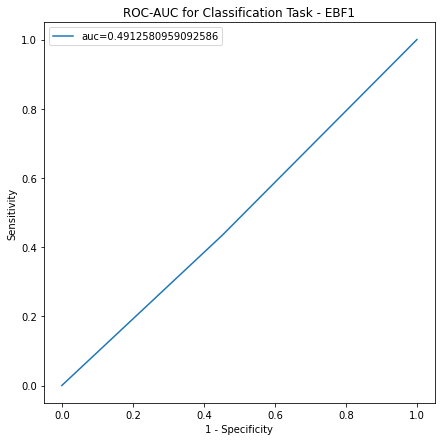

================  ELF1  ================
0.07190101946351779
[[ 55  45]
 [198 102]]
              precision    recall  f1-score   support

           0       0.22      0.55      0.31       100
           1       0.69      0.34      0.46       300

    accuracy                           0.39       400
   macro avg       0.46      0.45      0.38       400
weighted avg       0.57      0.39      0.42       400

=== Statistics ===
Test Accuracy: 0.393
Test Sensitivity: 0.340
Test Specificity: 0.550
Test F1-Score: 0.456


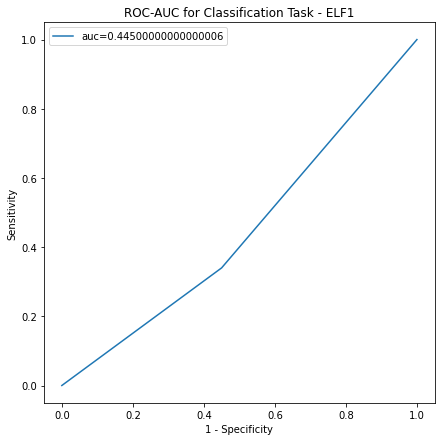

================  MAX  ================
0.1297916459543524
[[127  93]
 [ 92  88]]
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       220
           1       0.49      0.49      0.49       180

    accuracy                           0.54       400
   macro avg       0.53      0.53      0.53       400
weighted avg       0.54      0.54      0.54       400

=== Statistics ===
Test Accuracy: 0.537
Test Sensitivity: 0.489
Test Specificity: 0.577
Test F1-Score: 0.488


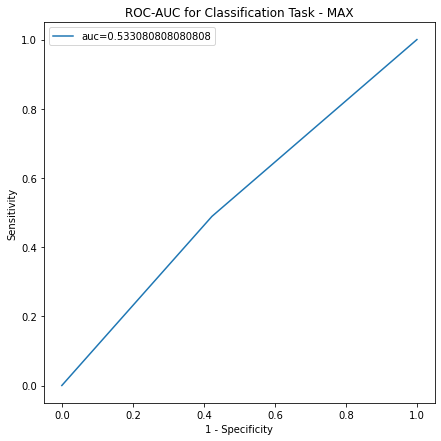

================  BHLHE40  ================
0.09841965527413712
[[117 118]
 [ 69  96]]
              precision    recall  f1-score   support

           0       0.63      0.50      0.56       235
           1       0.45      0.58      0.51       165

    accuracy                           0.53       400
   macro avg       0.54      0.54      0.53       400
weighted avg       0.55      0.53      0.54       400

=== Statistics ===
Test Accuracy: 0.532
Test Sensitivity: 0.582
Test Specificity: 0.498
Test F1-Score: 0.507


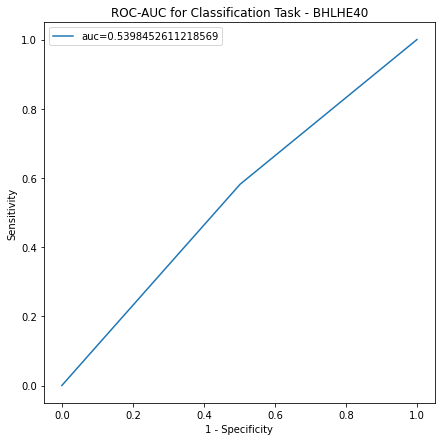

================  MXI1  ================
0.17414884945764625
[[136 157]
 [ 54  53]]
              precision    recall  f1-score   support

           0       0.72      0.46      0.56       293
           1       0.25      0.50      0.33       107

    accuracy                           0.47       400
   macro avg       0.48      0.48      0.45       400
weighted avg       0.59      0.47      0.50       400

=== Statistics ===
Test Accuracy: 0.472
Test Sensitivity: 0.495
Test Specificity: 0.464
Test F1-Score: 0.334


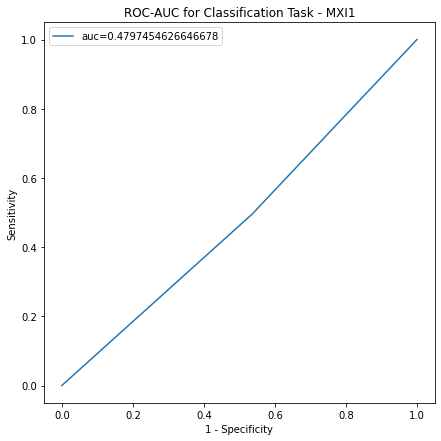

================  EGR1  ================
0.11713507111989518
[[156 178]
 [ 37  29]]
              precision    recall  f1-score   support

           0       0.81      0.47      0.59       334
           1       0.14      0.44      0.21        66

    accuracy                           0.46       400
   macro avg       0.47      0.45      0.40       400
weighted avg       0.70      0.46      0.53       400

=== Statistics ===
Test Accuracy: 0.463
Test Sensitivity: 0.439
Test Specificity: 0.467
Test F1-Score: 0.212


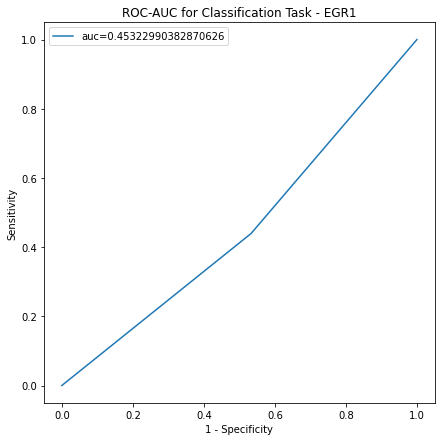

================  REST  ================
0.05350196008293021
[[186 177]
 [ 21  16]]
              precision    recall  f1-score   support

           0       0.90      0.51      0.65       363
           1       0.08      0.43      0.14        37

    accuracy                           0.51       400
   macro avg       0.49      0.47      0.40       400
weighted avg       0.82      0.50      0.61       400

=== Statistics ===
Test Accuracy: 0.505
Test Sensitivity: 0.432
Test Specificity: 0.512
Test F1-Score: 0.139


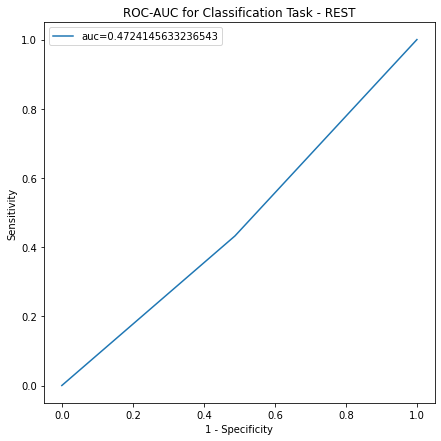

================  RELA  ================
0.14831630437152146
[[172 171]
 [ 30  27]]
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       343
           1       0.14      0.47      0.21        57

    accuracy                           0.50       400
   macro avg       0.49      0.49      0.42       400
weighted avg       0.75      0.50      0.57       400

=== Statistics ===
Test Accuracy: 0.497
Test Sensitivity: 0.474
Test Specificity: 0.501
Test F1-Score: 0.212


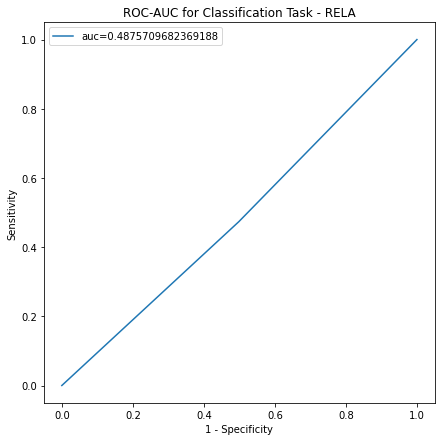

================  TCF12  ================
0.052072823373859635
[[ 90  99]
 [116  95]]
              precision    recall  f1-score   support

           0       0.44      0.48      0.46       189
           1       0.49      0.45      0.47       211

    accuracy                           0.46       400
   macro avg       0.46      0.46      0.46       400
weighted avg       0.46      0.46      0.46       400

=== Statistics ===
Test Accuracy: 0.463
Test Sensitivity: 0.450
Test Specificity: 0.476
Test F1-Score: 0.469


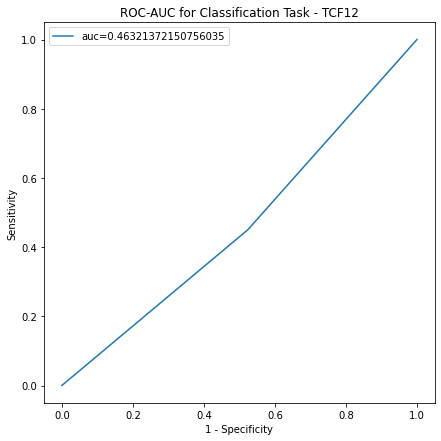

================  RUNX3  ================
0.14156101158658796
[[142 150]
 [ 57  51]]
              precision    recall  f1-score   support

           0       0.71      0.49      0.58       292
           1       0.25      0.47      0.33       108

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.45       400
weighted avg       0.59      0.48      0.51       400

=== Statistics ===
Test Accuracy: 0.482
Test Sensitivity: 0.472
Test Specificity: 0.486
Test F1-Score: 0.330


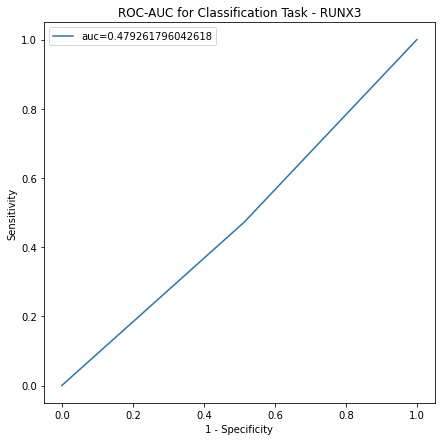

================  SIN3A  ================
0.11254525632915652
[[174 154]
 [ 39  33]]
              precision    recall  f1-score   support

           0       0.82      0.53      0.64       328
           1       0.18      0.46      0.25        72

    accuracy                           0.52       400
   macro avg       0.50      0.49      0.45       400
weighted avg       0.70      0.52      0.57       400

=== Statistics ===
Test Accuracy: 0.517
Test Sensitivity: 0.458
Test Specificity: 0.530
Test F1-Score: 0.255


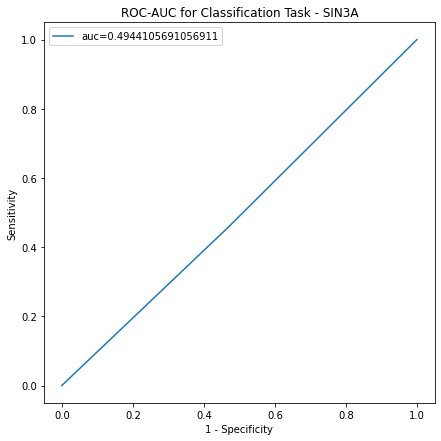

================  NFYB  ================
0.07763525540117673
[[195 156]
 [ 25  24]]
              precision    recall  f1-score   support

           0       0.89      0.56      0.68       351
           1       0.13      0.49      0.21        49

    accuracy                           0.55       400
   macro avg       0.51      0.52      0.45       400
weighted avg       0.79      0.55      0.63       400

=== Statistics ===
Test Accuracy: 0.547
Test Sensitivity: 0.490
Test Specificity: 0.556
Test F1-Score: 0.210


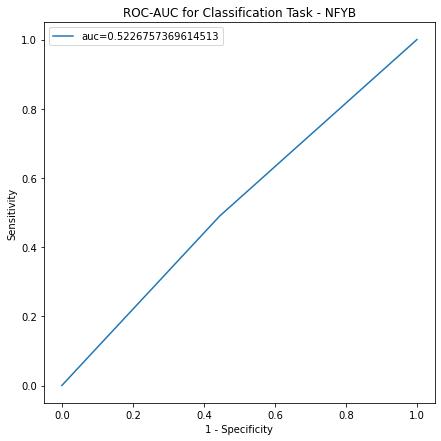

================  NFIC  ================
0.19800174589162184
[[128 133]
 [ 77  62]]
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       261
           1       0.32      0.45      0.37       139

    accuracy                           0.48       400
   macro avg       0.47      0.47      0.46       400
weighted avg       0.52      0.47      0.49       400

=== Statistics ===
Test Accuracy: 0.475
Test Sensitivity: 0.446
Test Specificity: 0.490
Test F1-Score: 0.371


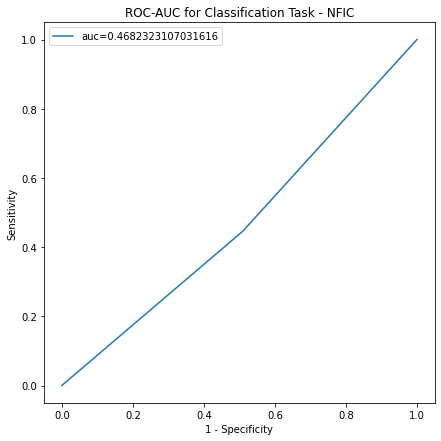

================  PAX5  ================
0.07600269023385478
[[ 66  54]
 [149 131]]
              precision    recall  f1-score   support

           0       0.31      0.55      0.39       120
           1       0.71      0.47      0.56       280

    accuracy                           0.49       400
   macro avg       0.51      0.51      0.48       400
weighted avg       0.59      0.49      0.51       400

=== Statistics ===
Test Accuracy: 0.492
Test Sensitivity: 0.468
Test Specificity: 0.550
Test F1-Score: 0.563


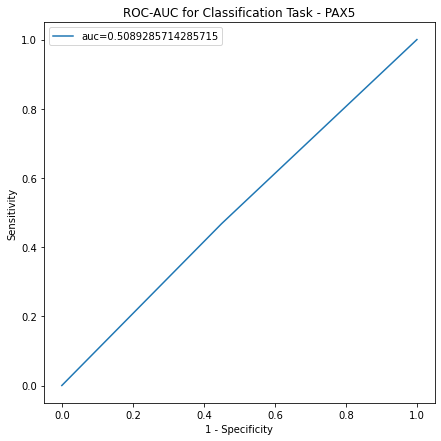

================  NFATC1  ================
0.0875226197801725
[[171 131]
 [ 58  40]]
              precision    recall  f1-score   support

           0       0.75      0.57      0.64       302
           1       0.23      0.41      0.30        98

    accuracy                           0.53       400
   macro avg       0.49      0.49      0.47       400
weighted avg       0.62      0.53      0.56       400

=== Statistics ===
Test Accuracy: 0.527
Test Sensitivity: 0.408
Test Specificity: 0.566
Test F1-Score: 0.297


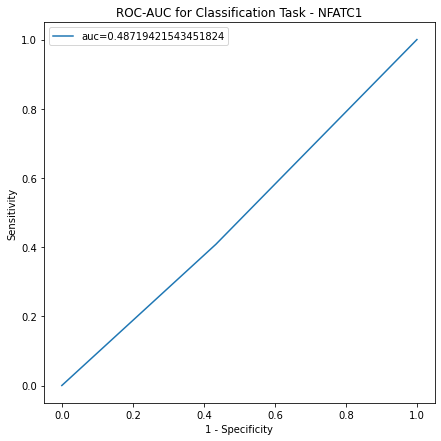

================  SPI1  ================
0.06717903019467808
[[105  87]
 [117  91]]
              precision    recall  f1-score   support

           0       0.47      0.55      0.51       192
           1       0.51      0.44      0.47       208

    accuracy                           0.49       400
   macro avg       0.49      0.49      0.49       400
weighted avg       0.49      0.49      0.49       400

=== Statistics ===
Test Accuracy: 0.490
Test Sensitivity: 0.438
Test Specificity: 0.547
Test F1-Score: 0.472


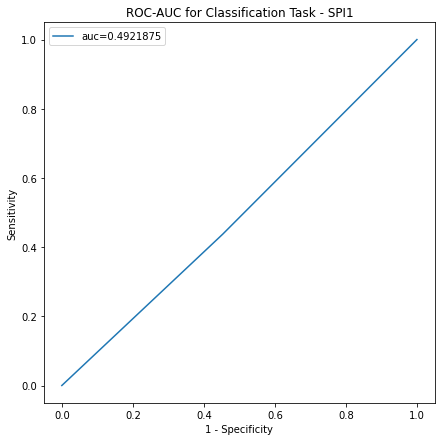

================  USF2  ================
0.11367962479640495
[[111  88]
 [114  87]]
              precision    recall  f1-score   support

           0       0.49      0.56      0.52       199
           1       0.50      0.43      0.46       201

    accuracy                           0.49       400
   macro avg       0.50      0.50      0.49       400
weighted avg       0.50      0.49      0.49       400

=== Statistics ===
Test Accuracy: 0.495
Test Sensitivity: 0.433
Test Specificity: 0.558
Test F1-Score: 0.463


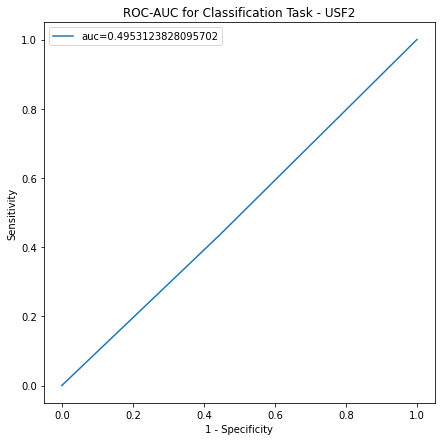

================  ZEB1  ================
0.15681231441263244
[[148 117]
 [ 78  57]]
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       265
           1       0.33      0.42      0.37       135

    accuracy                           0.51       400
   macro avg       0.49      0.49      0.49       400
weighted avg       0.54      0.51      0.52       400

=== Statistics ===
Test Accuracy: 0.512
Test Sensitivity: 0.422
Test Specificity: 0.558
Test F1-Score: 0.369


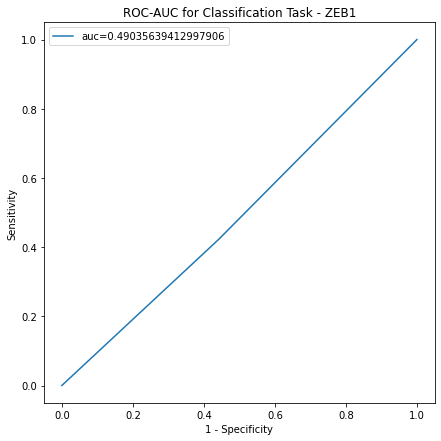

================  USF1  ================
0.041209890481122634
[[164 149]
 [ 50  37]]
              precision    recall  f1-score   support

           0       0.77      0.52      0.62       313
           1       0.20      0.43      0.27        87

    accuracy                           0.50       400
   macro avg       0.48      0.47      0.45       400
weighted avg       0.64      0.50      0.55       400

=== Statistics ===
Test Accuracy: 0.502
Test Sensitivity: 0.425
Test Specificity: 0.524
Test F1-Score: 0.271


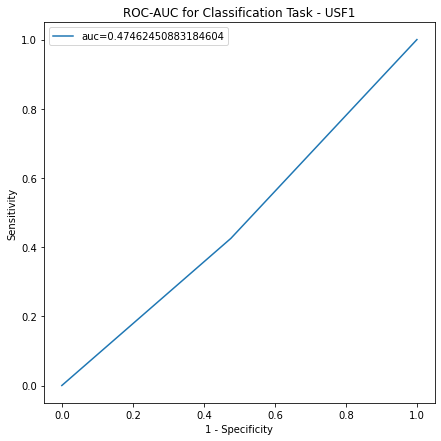

================  TCF3  ================
0.09816755894182293
[[107 115]
 [102  76]]
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       222
           1       0.40      0.43      0.41       178

    accuracy                           0.46       400
   macro avg       0.45      0.45      0.45       400
weighted avg       0.46      0.46      0.46       400

=== Statistics ===
Test Accuracy: 0.458
Test Sensitivity: 0.427
Test Specificity: 0.482
Test F1-Score: 0.412


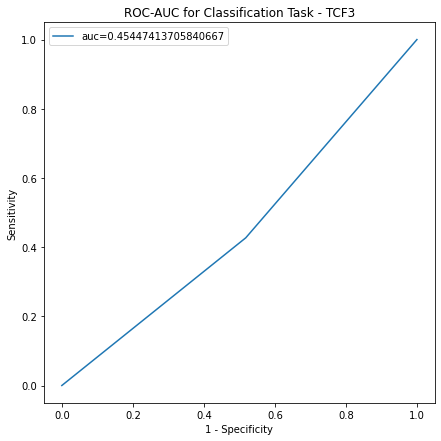

================  ZNF143  ================
0.03500987661172933
[[165 176]
 [ 29  30]]
              precision    recall  f1-score   support

           0       0.85      0.48      0.62       341
           1       0.15      0.51      0.23        59

    accuracy                           0.49       400
   macro avg       0.50      0.50      0.42       400
weighted avg       0.75      0.49      0.56       400

=== Statistics ===
Test Accuracy: 0.487
Test Sensitivity: 0.508
Test Specificity: 0.484
Test F1-Score: 0.226


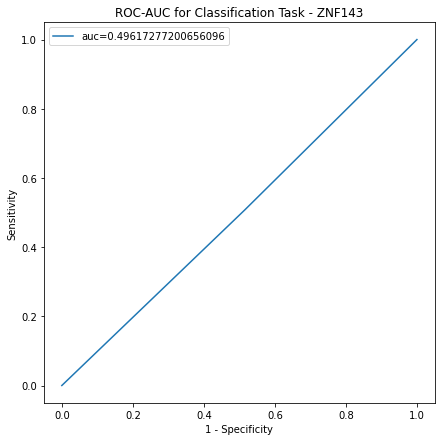

================  YY1  ================
0.041086971521744724
[[164 103]
 [ 82  51]]
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       267
           1       0.33      0.38      0.36       133

    accuracy                           0.54       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.56      0.54      0.54       400

=== Statistics ===
Test Accuracy: 0.537
Test Sensitivity: 0.383
Test Specificity: 0.614
Test F1-Score: 0.355


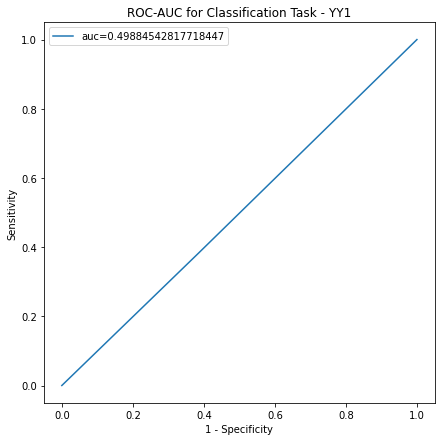

In [142]:
stat_file = open(res_folder + '/' + 'statistics.tsv', 'w')
stat_file.write("TF Name\tAccuracy\tSensitivity\tSpecificity\tF1 Score\tAUROC\n")
stat_file.flush()
for i in range(len(tf_list)):
  tf = tf_list[i]
  print("================ ", tf, " ================")
  binding_threshold = np.average(binding_dict[tf])
  print(binding_threshold)
  y_pred_binary = (y_pred[:, i] > binding_threshold) * 1
  y_true_binary = (y_true[:, i] > binding_threshold) * 1
  #print(y_true_binary)
  statistics = classification_statistics(y_true_binary, y_pred_binary)
  #print(type(statistics))
  #print(statistics)
  auroc = roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)
  stat_file.write(tf + "\t" + str(statistics['accuracy']) + "\t" + str(statistics['sensitivity']) + "\t" +
                  str(statistics['specificity']) + "\t" + str(statistics['f1score']) +
                  "\t" + str(auroc) + "\n")
  stat_file.flush()
  
stat_file.close()

In [143]:
learned_weight = model.conv1.weight.data
print(learned_weight.shape)
learned_weight = learned_weight.squeeze().cpu().detach().numpy()
print(learned_weight.shape)
initial_weight = weight.cpu().squeeze().cpu().detach().numpy()
print(initial_weight.shape)

matrix = []

pos = ['Position-' + str(j+1) for j in range(len(learned_weight[0]))]
for i in range(len(learned_weight)):
  column = []
  for j in range(len(learned_weight[0])):
    learned = learned_weight[i, j, :]
    initial = initial_weight[i, j, :]
    column.append(pearsonr(learned, initial)[0])
  matrix.append(column)
df = pd.DataFrame(matrix, columns=pos)
df['TF'] = tf_list
df.to_csv(res_folder + '/weights.tsv', sep='\t', index=False)

torch.Size([26, 1, 30, 4])
(26, 30, 4)
(26, 30, 4)
